# Rock Paper Scissors CNN
## Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import torch.nn.functional as F
torch.manual_seed(42)

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Defining a Dataset Class
In this section, we define a dataset class, `RPSDataset`. The class will take in a data directory (`data_dir`), transformations (`transform`). The class uses the `datasets.ImageFolder` class to load images from a folder.

As required, the `__len__` and `__getitem__` methods are included.

In [4]:
# Define overall dataset class
class RPSDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

## Defining Transformations

In [5]:
# Define the transforms to use
data_transforms = transforms.Compose([
    transforms.Resize((90, 90)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Defining Datasets

In [6]:
# Create and Split Dataset
dataset = RPSDataset('image_data/', transform=data_transforms)
train_dataset, test_dataset, validation_dataset = random_split(dataset, [1000, 350, 150])

## Marking Classes

In [7]:
class_to_idx = train_dataset.dataset.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes = train_dataset.dataset.dataset.classes

print(f"""{class_to_idx=}
{idx_to_class=}
{classes=}
""")

class_to_idx={'paper': 0, 'rock': 1, 'scissors': 2}
idx_to_class={0: 'paper', 1: 'rock', 2: 'scissors'}
classes=['paper', 'rock', 'scissors']



## Defining Data Loaders

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

In [9]:
# Exploring one of the DataLoaders
for idx, batch in enumerate(train_loader):
    print('Batch index: ', idx)
    print('Batch size: ', batch[0].size())
    print('Batch labels: ', batch[1])
    break

Batch index:  0
Batch size:  torch.Size([32, 3, 90, 90])
Batch labels:  tensor([2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 2,
        0, 0, 0, 1, 2, 0, 1, 0])


We can see that the DataLoader returns batches of 32. This gives us a Tensor that contains 32 images each with:
* 3 channels
* 90 width
* 90 height

The labels for each image are included in the second item of the batch, as a Tensor. We can access the classes by name using the dictionary we created earlier.

## Displaying a Single Transformed Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


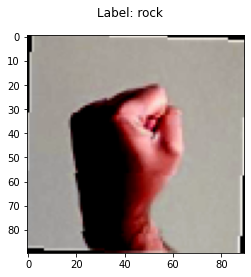

In [10]:
# Showing a single transformed image
def show_idx(dataloader, idx):
    for _, batch in enumerate(dataloader):
        images = batch[0]
        labels = batch[1]
        break

    fig, ax = plt.subplots()
    fig.suptitle(f"Label: {idx_to_class.get(int(labels[idx]))}")
    ax.imshow(images[idx].permute(1,2,0))
    plt.show()

show_idx(train_loader, 4)

## Defining a CNN Architecture

In [11]:
class RPSClassifier(nn.Module):
    def __init__(self):
        super(RPSClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 20 * 20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
# Instantiating the Model
model = RPSClassifier()

In [13]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Running the Training Loop

In [41]:
best_val_loss = float("inf")
patience = 0
max_patience = 6

num_epochs = 200

def validate(model, val_loader, criterion):
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    val_loss, val_accuracy = validate(model, validation_loader, criterion)
    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1):02.5f} ------ Validation Loss: {val_loss:02.5f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), "best_model.pth")

    else:
        patience += 1

    if patience >= max_patience:
        print("Early stopping reached")
        break

Epoch 1, Loss: 1.09485 ------ Validation Loss: 1.07837, Validation Accuracy: 36.00%
Epoch 2, Loss: 1.03537 ------ Validation Loss: 1.10860, Validation Accuracy: 44.00%
Epoch 3, Loss: 0.80445 ------ Validation Loss: 0.74811, Validation Accuracy: 60.67%
Epoch 4, Loss: 0.64169 ------ Validation Loss: 0.61857, Validation Accuracy: 77.33%
Epoch 5, Loss: 0.39727 ------ Validation Loss: 0.32215, Validation Accuracy: 91.33%
Epoch 6, Loss: 0.24766 ------ Validation Loss: 0.22457, Validation Accuracy: 90.67%
Epoch 7, Loss: 0.19723 ------ Validation Loss: 0.14143, Validation Accuracy: 98.00%
Epoch 8, Loss: 0.09295 ------ Validation Loss: 0.41673, Validation Accuracy: 84.67%
Epoch 9, Loss: 0.14032 ------ Validation Loss: 0.06844, Validation Accuracy: 97.33%
Epoch 10, Loss: 0.08834 ------ Validation Loss: 0.08149, Validation Accuracy: 98.67%
Epoch 11, Loss: 0.05274 ------ Validation Loss: 0.01332, Validation Accuracy: 100.00%
Epoch 12, Loss: 0.02534 ------ Validation Loss: 0.03137, Validation Accur

## Evaluating the CNN
Let's look at an entire folder of images to see if they're correct.

In [18]:
# Load the model weights
model = RPSClassifier()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

RPSClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [20]:
correct = 0
for i in range(1, 501):
    image_path = f'image_data/paper/{i}.jpg'
    with torch.no_grad():
        image = Image.open(image_path)
        
        # Apply the same transformations as during training and add batch dimension
        image_tensor = data_transforms(image).unsqueeze(0)  
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    predicted_label = predicted
    predicted_class = idx_to_class.get(int(predicted_label))
    if predicted_class == 'paper':
        correct += 1

correct


500

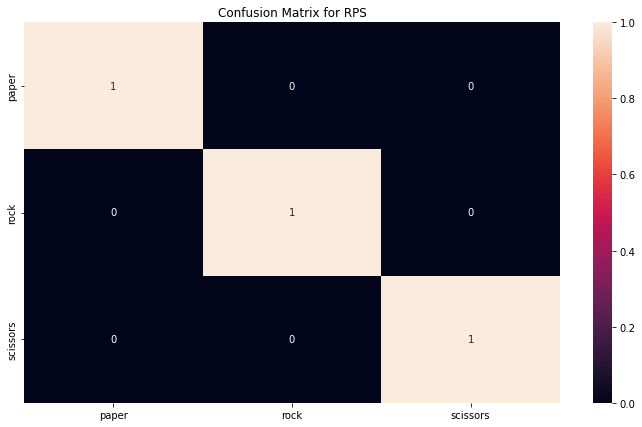

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix for RPS')
plt.show();